In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv("../datasets/sample_livestock_data.csv")
df.head()

,goat_id,age,sex,weight_kg,milk_yield_l,temperature_c,previous_issues,last_breeding_date,parent_m,parent_f,health_flag
0,G001,3,F,38,1.8,39.4,1,2024-07-12,G010,G022,1
1,G002,2,F,33,1.4,38.7,0,2024-08-01,G015,G025,0
2,G003,5,M,45,0.0,39.8,1,2023-11-09,G007,G014,1
3,G004,1,F,28,0.9,38.5,0,2024-09-20,G003,G012,0
4,G005,4,F,41,1.7,39.1,1,2024-06-14,G011,G023,1


In [2]:
# Convert to datetime
df['last_breeding_date'] = pd.to_datetime(df['last_breeding_date'], errors='coerce')

# Feature: days since last breeding
reference_date = pd.to_datetime("2024-09-01")
df['days_since_last_breeding'] = (reference_date - df['last_breeding_date']).dt.days

# Convert sex to categorical
df['sex'] = df['sex'].astype('category')

# Target variable
y = df['health_flag']

# Features we will use
features = [
    'age', 'sex', 'weight_kg', 'milk_yield_l', 'temperature_c',
    'previous_issues', 'days_since_last_breeding'
]

X = df[features]

df.head()

,goat_id,age,sex,weight_kg,milk_yield_l,temperature_c,previous_issues,last_breeding_date,parent_m,parent_f,health_flag,days_since_last_breeding
0,G001,3,F,38,1.8,39.4,1,2024-07-12,G010,G022,1,51
1,G002,2,F,33,1.4,38.7,0,2024-08-01,G015,G025,0,31
2,G003,5,M,45,0.0,39.8,1,2023-11-09,G007,G014,1,297
3,G004,1,F,28,0.9,38.5,0,2024-09-20,G003,G012,0,-19
4,G005,4,F,41,1.7,39.1,1,2024-06-14,G011,G023,1,79


In [3]:
df.describe()

,age,weight_kg,milk_yield_l,temperature_c,previous_issues,last_breeding_date,health_flag,days_since_last_breeding
count,20.000000,20.000000,20.00000,20.000000,20.000000,20,20.000000,20.000000
mean,3.400000,38.500000,0.95500,39.150000,0.500000,2024-06-06 09:36:00,0.500000,86.600000
min,1.000000,28.000000,0.00000,38.400000,0.000000,2023-09-29 00:00:00,0.000000,-24.000000
25%,2.000000,34.750000,0.00000,38.700000,0.000000,2024-06-13 00:00:00,0.000000,24.250000
50%,3.000000,39.500000,1.25000,39.050000,0.500000,2024-07-18 12:00:00,0.500000,44.500000
75%,4.250000,42.250000,1.62500,39.525000,1.000000,2024-08-07 18:00:00,1.000000,80.000000
max,6.000000,47.000000,1.90000,40.100000,1.000000,2024-09-25 00:00:00,1.000000,338.000000
std,1.500877,5.375382,0.77424,0.507315,0.512989,NaN,0.512989,117.702748


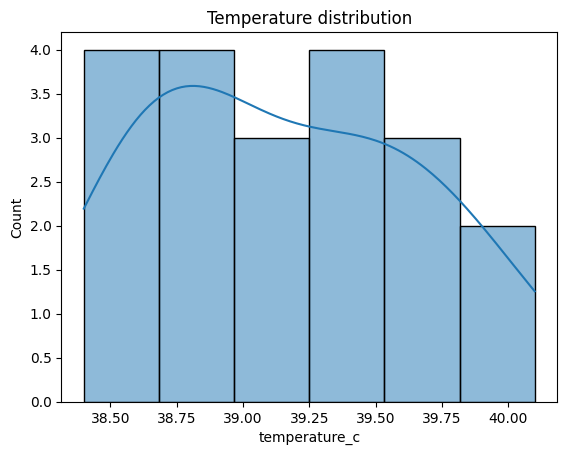

In [4]:
sns.histplot(df['temperature_c'], kde=True)
plt.title("Temperature distribution")
plt.show()

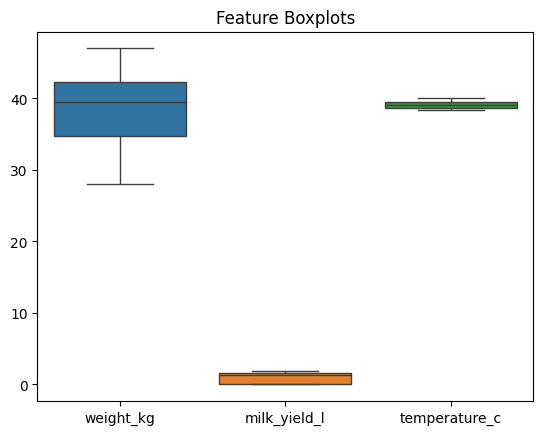

In [5]:
sns.boxplot(data=df[['weight_kg','milk_yield_l','temperature_c']])
plt.title("Feature Boxplots")
plt.show()

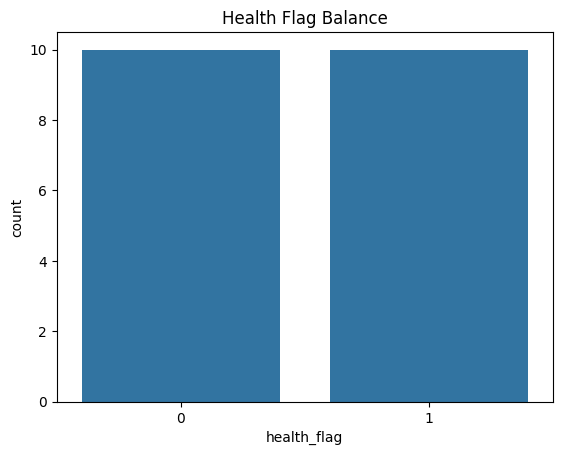

In [6]:
sns.countplot(x=y)
plt.title("Health Flag Balance")
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [8]:
numeric_features = ['age','weight_kg','milk_yield_l','temperature_c','days_since_last_breeding']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])

categorical_features = ['sex','previous_issues']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [9]:
log_reg_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(class_weight='balanced', max_iter=200))
])

rf_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=200, 
        class_weight='balanced',
        random_state=42
    ))
])

log_reg_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Logistic Regression results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

ROC AUC: 1.0


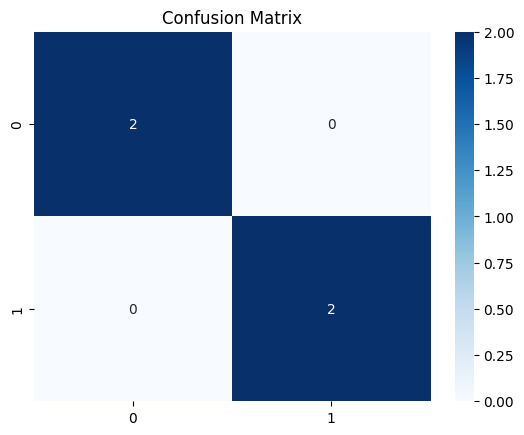

Random Forest results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

ROC AUC: 1.0


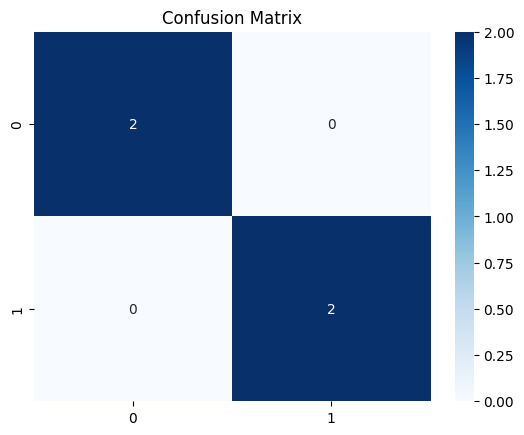

In [10]:
def evaluate(model, X_test, y_test):
    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:,1]
    
    print(classification_report(y_test, preds))
    print("ROC AUC:", roc_auc_score(y_test, proba))
    
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

print("Logistic Regression results:")
evaluate(log_reg_clf, X_test, y_test)

print("Random Forest results:")
evaluate(rf_clf, X_test, y_test)

In [11]:
import pickle
best_model = rf_clf   # if RF performed better

with open("../models/health_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("Model saved successfully.")

Model saved successfully.


In [12]:
def predict_health(goat_row_dict):
    """
    goat_row_dict example:
    {
      'age': 3,
      'sex': 'F',
      'weight_kg': 38,
      'milk_yield_l': 1.8,
      'temperature_c': 39.2,
      'previous_issues': 1,
      'days_since_last_breeding': 50
    }
    """
    df_input = pd.DataFrame([goat_row_dict])
    proba = best_model.predict_proba(df_input)[0][1]
    pred = int(proba > 0.5)
    
    return {"prediction": pred, "probability_unhealthy": float(proba)}

In [13]:
example = {
    'age': 3,
    'sex': 'F',
    'weight_kg': 38,
    'milk_yield_l': 1.4,
    'temperature_c': 39.4,
    'previous_issues': 1,
    'days_since_last_breeding': 40
}

predict_health(example)

{'prediction': 1, 'probability_unhealthy': 0.695}